In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import autorootcwd
import numpy as np
import librosa
import os
from librosa.display import specshow
import matplotlib.pyplot as plt

from src.utils import get_cqt, get_filenames, get_chord_annotation, SR, HOP_LENGTH, BINS_PER_OCTAVE, get_annotation_metadata

In [5]:
idx = 219
filenames = get_filenames()
cqt = get_cqt('cyndilauper_girlsjustwanttohavefun', return_as_tensor=False).T
metadata = get_annotation_metadata(filenames[idx])
title = f"{metadata['title']} - {metadata['artist']}"

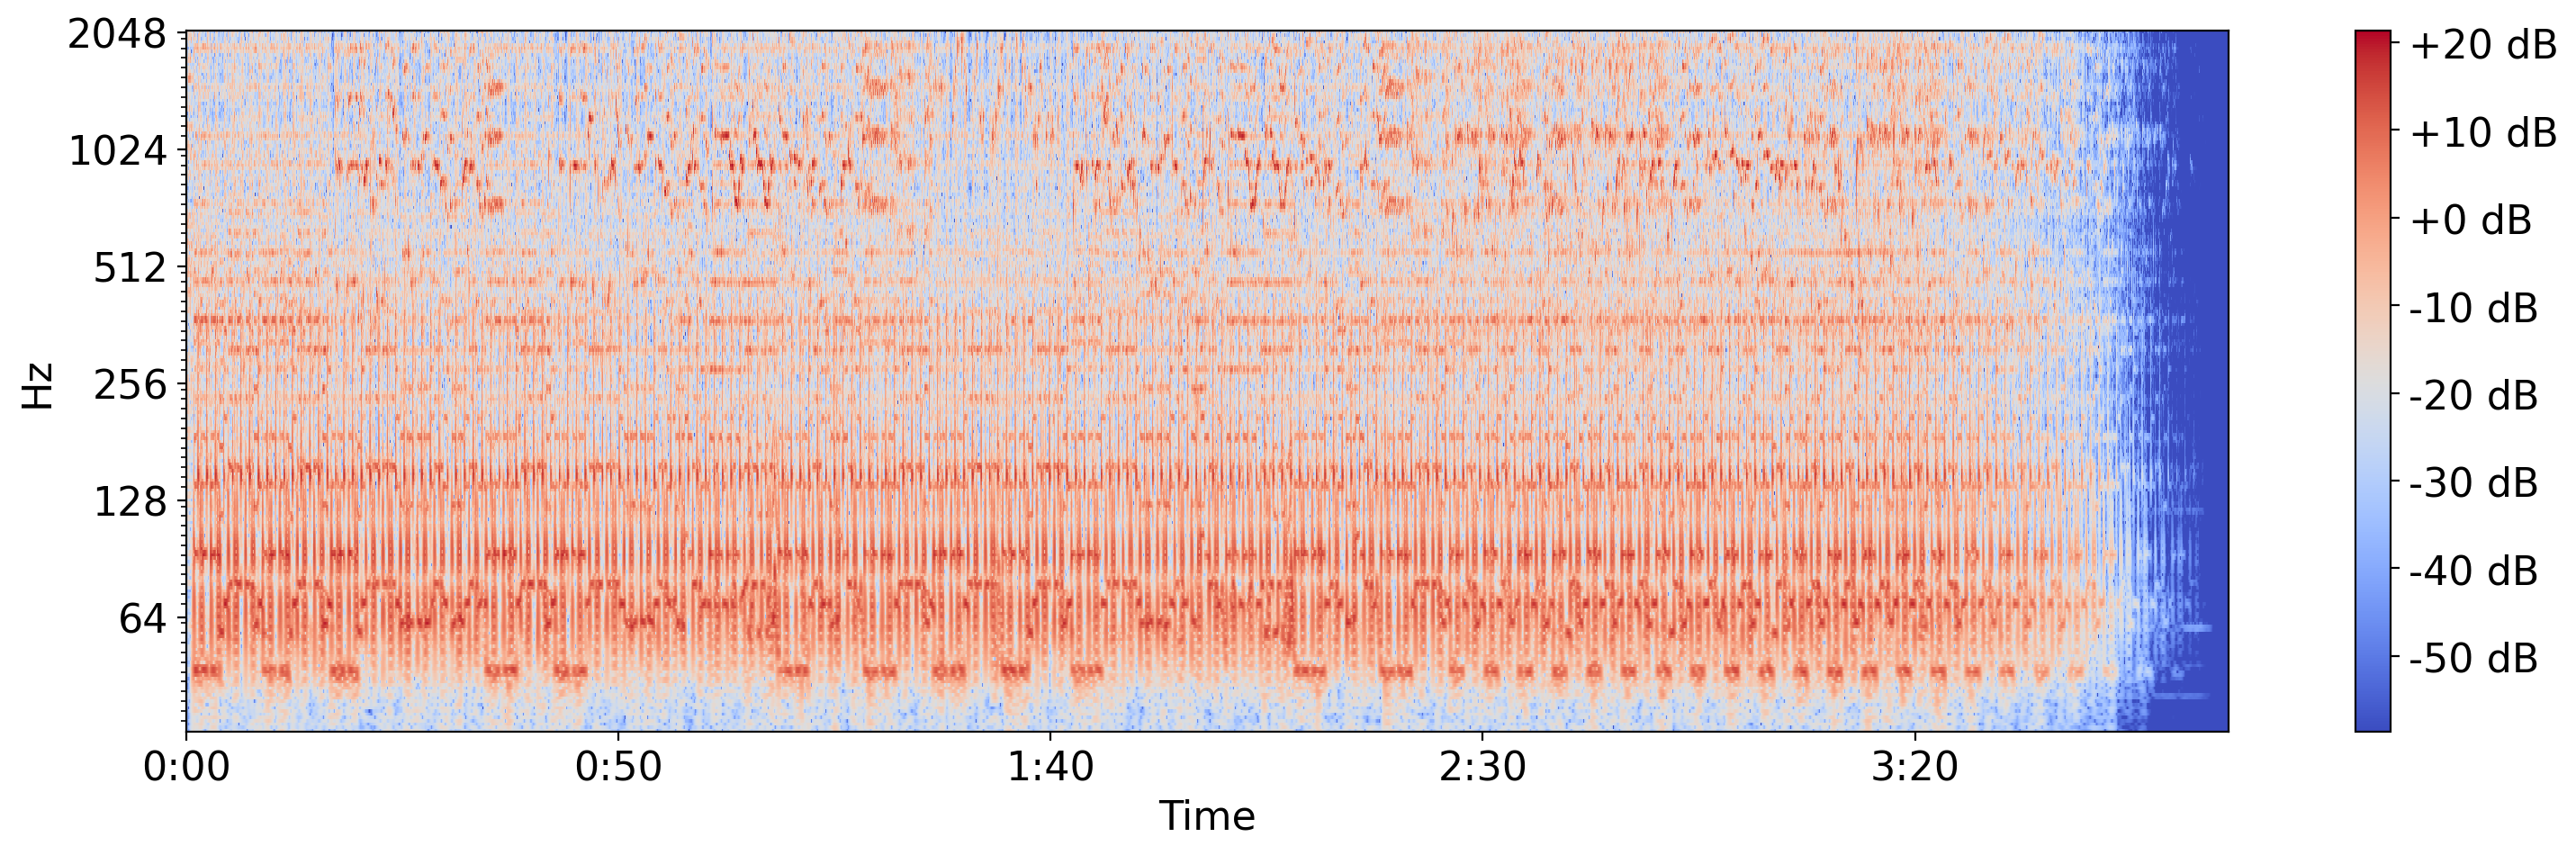

In [55]:
plt.figure(figsize=(30,5))
plt.subplot(1, 2, 2)
# Set font size and of axis labels
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16})
img = librosa.display.specshow(cqt, y_axis='cqt_hz', x_axis='time', sr=SR, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
plt.colorbar(img, format="%+2.f dB")
# plt.title(title)
plt.tight_layout()
# Save the figure to thesis/figures/sample_cqt.png in high quality
plt.savefig("thesis/figures/sample_cqt.png", bbox_inches='tight', dpi=100)
plt.show()
plt.close()


'thebeatles_runforyourlife'

In [6]:
from scipy.signal import correlate
import jams
import librosa

import numpy as np

def get_chord_annotation(file_name):
    jam = jams.load(os.path.join('./data/processed/chords/', f'{file_name}.jams'))
    chord_ann = jam.annotations.search(namespace="chord")[0]
    return chord_ann.data

def convert_chords_to_binary(cqt, chords, sr, hop_length, duration):
    # Create a binary vector for chord changes where 1 indicates a chord change and 0 indicates no change
    # Assuming a time resolution similar to the spectrogram hop length
    binary_chords = np.zeros(cqt.shape[1])
    for chord in chords:
        start = librosa.time_to_frames(chord.time, sr=sr, hop_length=hop_length)
        # if start < len(binary_chords):
        binary_chords[start] = 1
    return binary_chords

def normalized_correlation(x, y):
    """Computes normalized cross-correlation"""
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    
    corr = correlate(x, y, mode='full')
    norm_factor = np.sqrt(np.sum(x**2) * np.sum(y**2))  # Normalization term
    return corr / norm_factor  # Normalize to get values in [-1, 1]

def get_max_corr(filename):
    cqt = get_cqt(filename, return_as_tensor=False).T
    chord_ann = get_chord_annotation(filename)
    binary_chords = convert_chords_to_binary(cqt, chord_ann, SR, HOP_LENGTH, cqt.shape[1])
    
    delta = librosa.feature.delta(cqt)  # (24*7, Frames)
    delta_magnitude = np.sqrt(np.sum(delta**2, axis=0))  # (Frames)

    # Standardize the features
    delta_magnitude = (delta_magnitude - np.mean(delta_magnitude)) / np.std(delta_magnitude)
    binary_chords = (binary_chords - np.mean(binary_chords)) / np.std(binary_chords)
    
    # Compute normalized correlation
    corr = normalized_correlation(delta_magnitude, binary_chords)
    
    lags = np.arange(-len(binary_chords)+1, len(binary_chords))
    max_lag = lags[np.argmax(corr)]
    
    return max_lag, corr, lags, len(binary_chords)


Maximum correlation lag: -2 frames


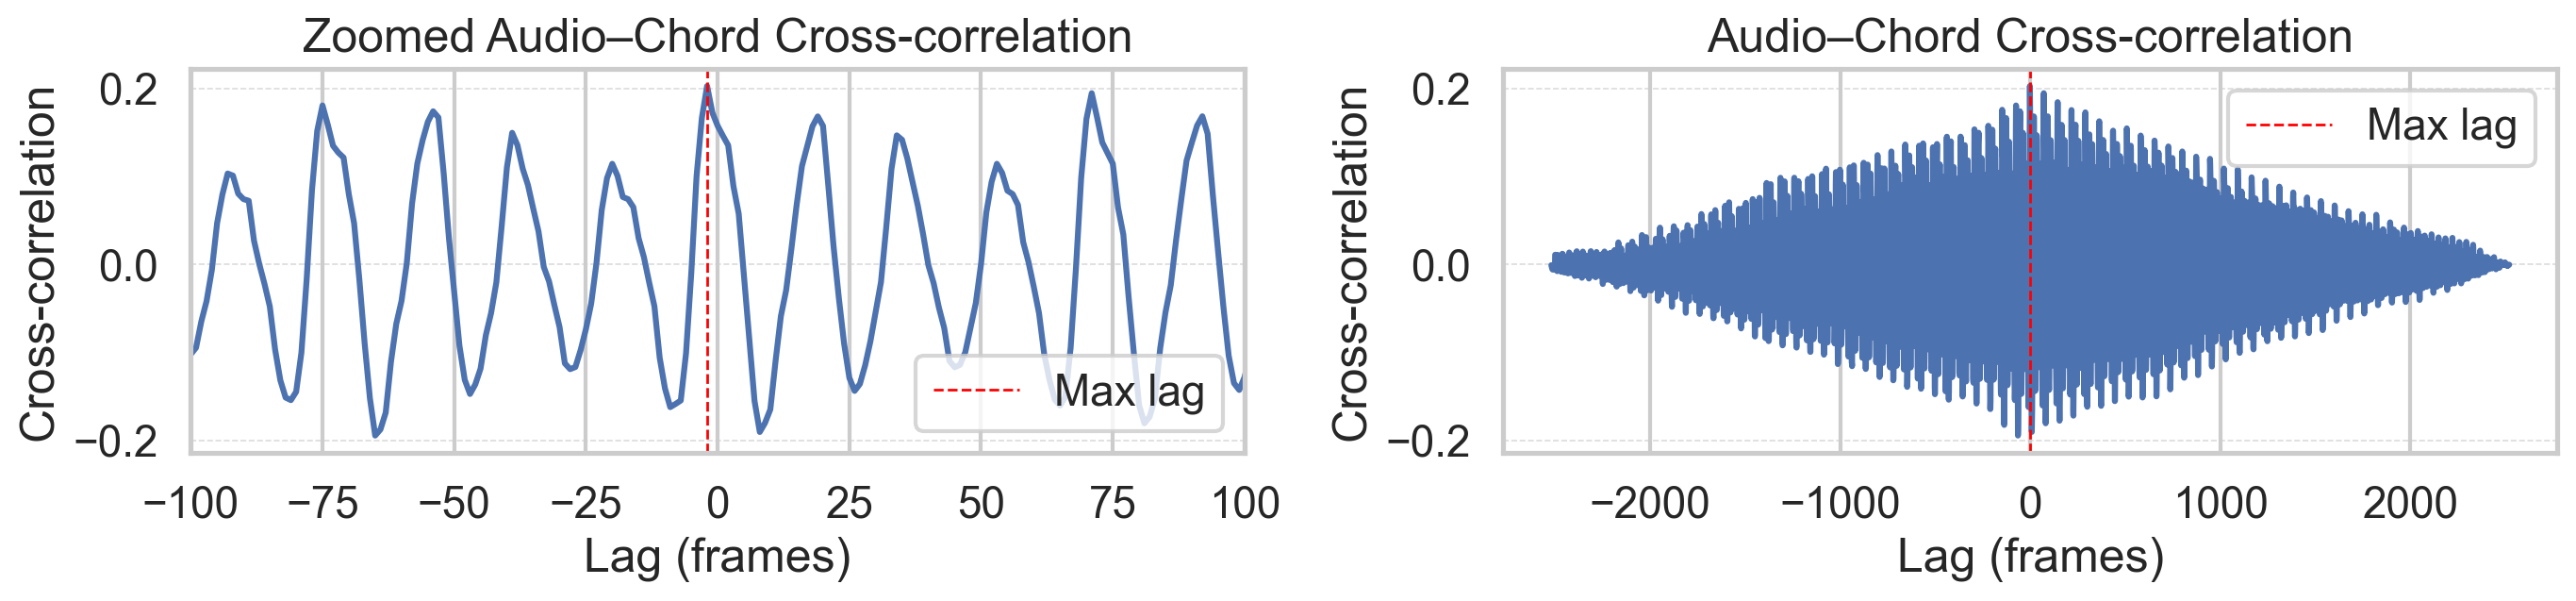

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean, publication-style theme
sns.set(style="whitegrid", context="talk")

filename = filenames[0]
max_lag, corr, lags, _ = get_max_corr(filename)
print(f'Maximum correlation lag: {max_lag} frames')

# Set up the subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))
plt.subplots_adjust(wspace=0.3)

# Plot full cross-correlation
sns.lineplot(x=lags, y=corr, ax=axs[1])
axs[1].set_title("Audio–Chord Cross-correlation")
axs[1].set_xlabel("Lag (frames)")
axs[1].set_ylabel("Cross-correlation")

# Plot zoomed-in view
sns.lineplot(x=lags, y=corr, ax=axs[0])
axs[0].set_xlim(-100, 100)
axs[0].set_title("Zoomed Audio–Chord Cross-correlation")
axs[0].set_xlabel("Lag (frames)")
axs[0].set_ylabel("Cross-correlation")

# Fine-tune each axis
for ax in axs:
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.axvline(x=max_lag, color='red', linestyle='--', linewidth=1, label='Max lag')
    ax.legend()
    ax.set_axisbelow(True)

# Save the plot
plt.tight_layout()
plt.savefig("thesis/figures/cross_correlation.png", bbox_inches='tight', dpi=150)
plt.show()

# Duration and Max Corr Figure

In [11]:
from tqdm import tqdm
import pandas as pd

# Only run if the csv doesn't exist
if not os.path.exists('data/max_lags.csv'):
    rows = []
    for file_name in tqdm(filenames):
        max, corr, lags, frames = get_max_corr(file_name)
        row = {
            'file_name': file_name,
            'max_lag': max
        }

        for window in [200, 100, 50, 25]:
            max_within = np.argmax(corr[frames-window:frames+window]) - window
            row.update({f'max_lag_{window}': max_within})
        
        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv('data/max_lags.csv', index=False)
else:
    df = pd.read_csv('data/max_lags.csv')


In [13]:
filenames = get_filenames()
duration_diffs = []
for filename in tqdm(filenames):
    lib = librosa.get_duration(filename=f'./data/processed/audio/{filename}.mp3')
    duration_chords = get_annotation_metadata(filename).duration
    diff = lib - duration_chords
    duration_diffs.append(diff)

  0%|          | 0/1213 [00:00<?, ?it/s]/var/folders/wv/rkgyh65d1jx0nzbn07gn8f380000gn/T/ipykernel_49459/4051348546.py:4: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  lib = librosa.get_duration(filename=f'./data/processed/audio/{filename}.mp3')
100%|██████████| 1213/1213 [00:20<00:00, 58.54it/s]


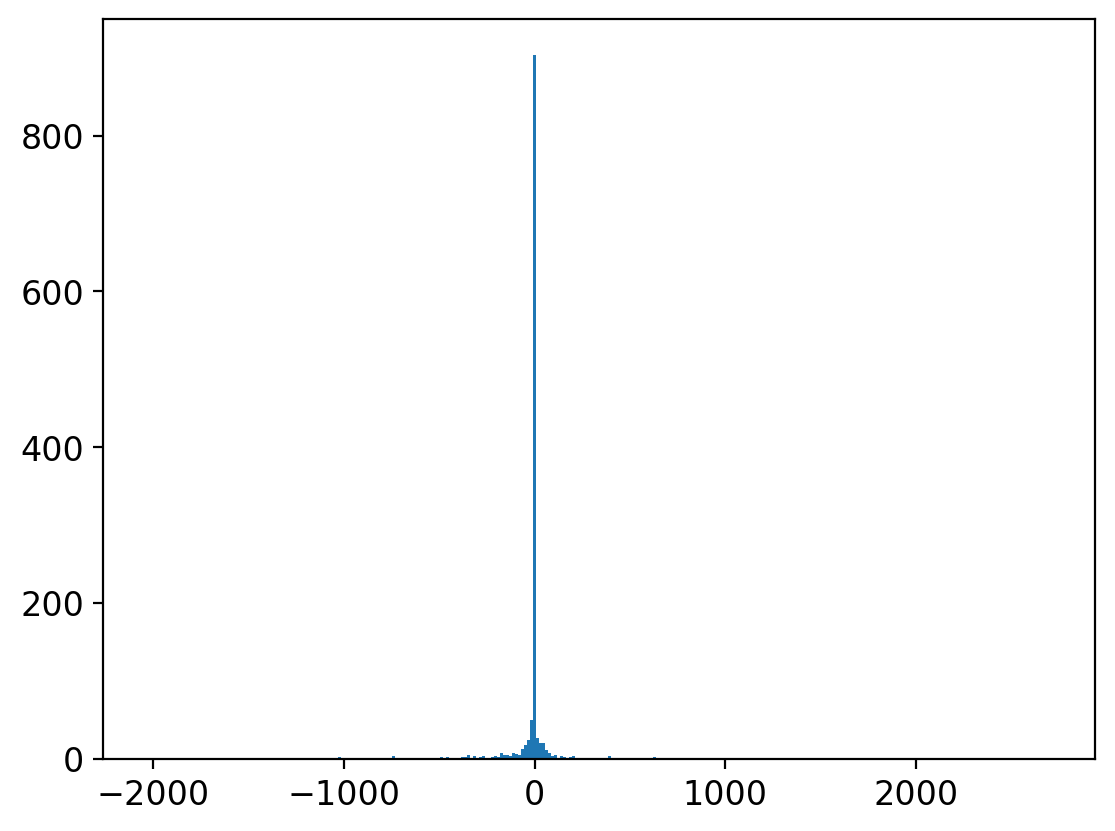

In [69]:
plt.hist(df['max_lag'], bins=300)
plt.show()

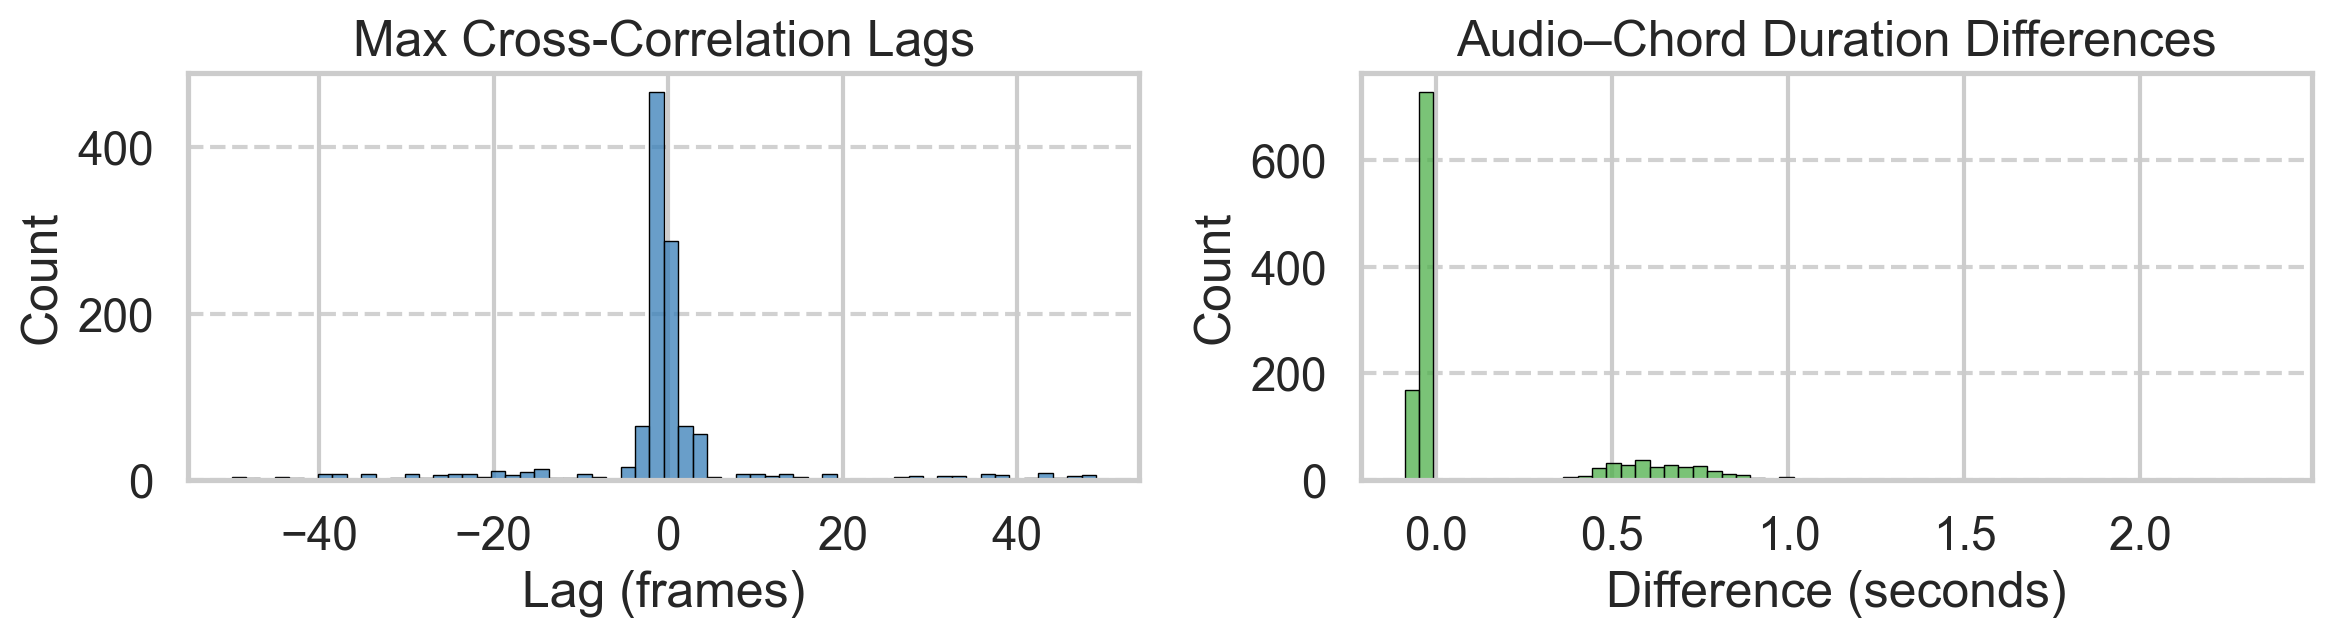

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a bold Seaborn style
sns.set(style="whitegrid", context="talk", palette="deep")

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))
plt.subplots_adjust(wspace=0.3)

# First histogram: Max lag
sns.histplot(
    df['max_lag_50'],
    bins=60,
    ax=axs[0],
    color=sns.color_palette("Set1")[1],  # Bold red
    edgecolor='black',
    linewidth=0.5
)
axs[0].set_xlabel('Lag (frames)')
axs[0].set_ylabel('Count')
axs[0].set_title('Max Cross-Correlation Lags')
axs[0].grid(axis='y', linestyle='--', alpha=0.9)
axs[0].set_axisbelow(True)

# Second histogram: Duration differences
sns.histplot(
    duration_diffs,
    bins=60,
    ax=axs[1],
    color=sns.color_palette("Set1")[2],  # Bold green
    edgecolor='black',
    linewidth=0.5
)
axs[1].set_xlabel('Difference (seconds)')
axs[1].set_ylabel('Count')
axs[1].set_title('Audio–Chord Duration Differences')
axs[1].grid(axis='y', linestyle='--', alpha=0.9)
axs[1].set_axisbelow(True)

# Save and show
plt.tight_layout()
plt.savefig("thesis/figures/duration_diffs_and_lags.png", bbox_inches='tight', dpi=200)
plt.show()

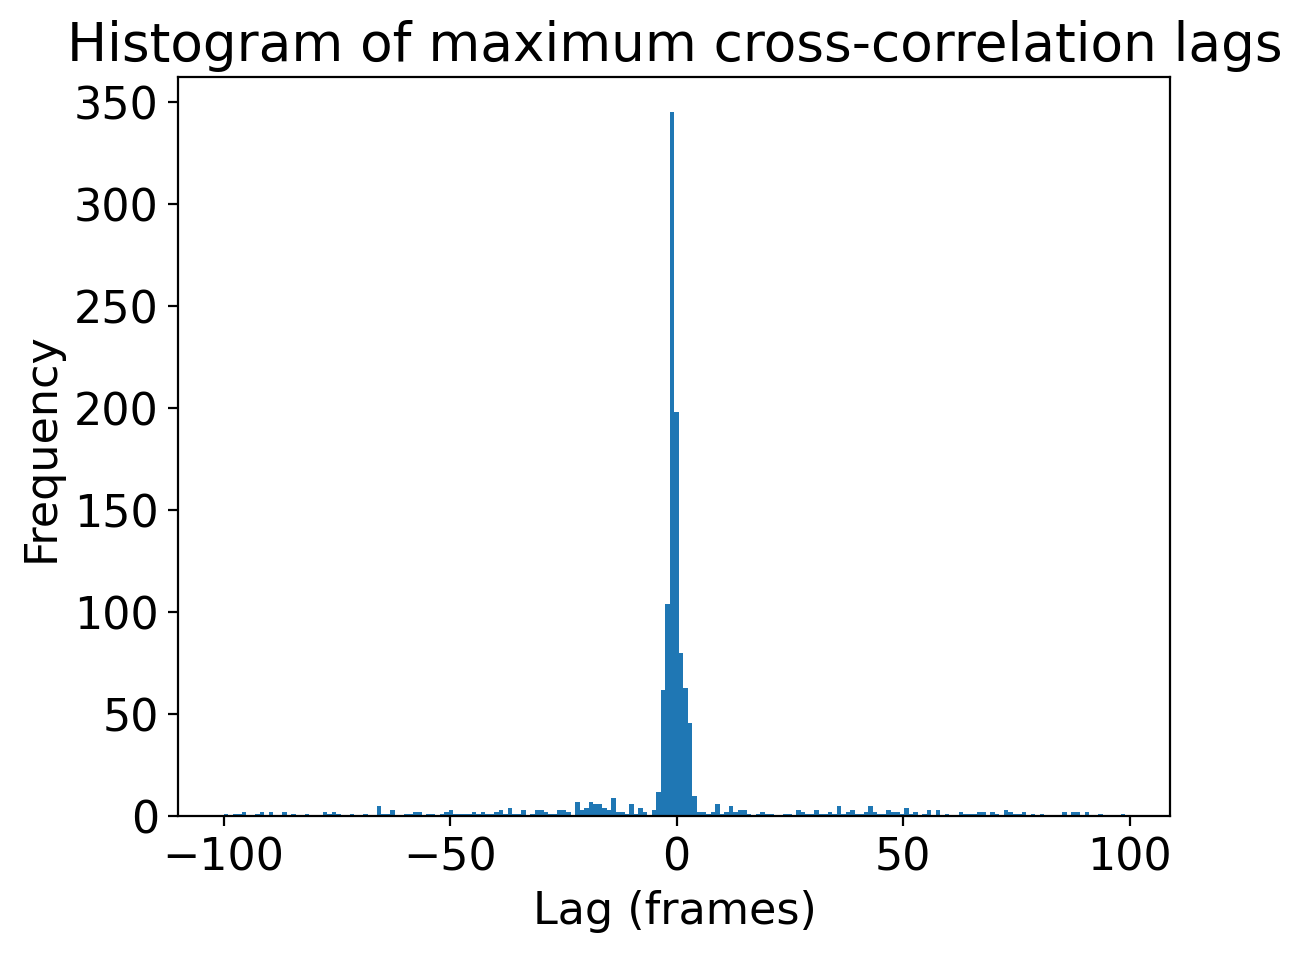

In [26]:
plt.hist(df['max_lag_100'], bins=200)
plt.xlabel('Lag (frames)')
plt.ylabel('Frequency')
plt.title('Histogram of maximum cross-correlation lags')
plt.show()

In [189]:
df

,file_name,max_lag,max_lag_200,max_lag_100,max_lag_50,max_lag_25
0,TR6R91L11C8A40D710,-66,-67,-67,49,-23
1,TRACGVT149E3B9BE3F,-2,-3,-3,-3,-3
2,TRACPPB149E33C10B9,-3,-4,-4,-4,-4
3,TRADINA127F847B84E,-87,-88,-88,-7,-7
4,TRAEQJQ149E3BA694B,-40,-41,-41,-41,-1
...,...,...,...,...,...,...
1212,TRZUUDG149E37F179C,-93,-94,-94,-10,-10
1213,TRZUXXY149E39C2D8E,3,2,2,2,2
1214,TRZWERX149E381FF71,-121,-122,-35,-35,1
1215,TRZWISM149E35CA148,-107,-108,-37,-37,-1
